<a href="https://colab.research.google.com/github/poonampal/AIML/blob/master/06_Transfer_Learning_Part3_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu May 18 02:14:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    42W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-05-18 02:14:56--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-05-18 02:14:56 (46.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

--2023-05-18 02:16:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 2607:f8b0:4023:c0b::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   137MB/s    in 11s     

2023-05-18 02:16:22 (140 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [7]:
import zipfile
zip_ref = zipfile.ZipFile('101_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

In [9]:
import os
for dirpaths, dirnames, filenames in os.walk('101_food_classes_10_percent'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} in '{dirpaths}'")

There are 2 directories and 0 in '101_food_classes_10_percent'
There are 101 directories and 0 in '101_food_classes_10_percent/train'
There are 0 directories and 75 in '101_food_classes_10_percent/train/dumplings'
There are 0 directories and 75 in '101_food_classes_10_percent/train/ceviche'
There are 0 directories and 75 in '101_food_classes_10_percent/train/cheese_plate'
There are 0 directories and 75 in '101_food_classes_10_percent/train/spring_rolls'
There are 0 directories and 75 in '101_food_classes_10_percent/train/hot_dog'
There are 0 directories and 75 in '101_food_classes_10_percent/train/tacos'
There are 0 directories and 75 in '101_food_classes_10_percent/train/cup_cakes'
There are 0 directories and 75 in '101_food_classes_10_percent/train/samosa'
There are 0 directories and 75 in '101_food_classes_10_percent/train/gnocchi'
There are 0 directories and 75 in '101_food_classes_10_percent/train/pad_thai'
There are 0 directories and 75 in '101_food_classes_10_percent/train/frenc

In [10]:
train_dir = '101_food_classes_10_percent/train/'
test_dir = '101_food_classes_10_percent/test/'

In [11]:
import tensorflow as tf


In [12]:
IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                                image_size=IMG_SIZE,
                                                                                label_mode='categorical')

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode='categorical',
                                                                shuffle=False)


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [16]:
train_data_all_10_percent.enumerate()

<_ZipDataset element_spec=(TensorSpec(shape=(), dtype=tf.int64, name=None), (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None)))>

In [17]:
train_data_all_10_percent.batch

<bound method DatasetV2.batch of <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>>

In [18]:
checkpoint_path = '101_classes_10_percent_data_model_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor='val_accuracy',
                                                         save_best_only=True)


In [20]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomZoom(0.2)
], name='data_augmentation')

In [26]:
len(train_data_all_10_percent.class_names)

101

In [27]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.Input(shape=(224,224,3), name='input_layer')
x = data_augmentation(inputs)

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name='global_average_pooling')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation='softmax', name='output_layer')(x)

model = tf.keras.Model(inputs, outputs)






In [28]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [29]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_2 (Rescaling)        (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_1 (Normalization  (None, None, None,   7          ['rescaling_2[0][0]']            
 )                              3)                                                   

In [30]:
model.compile(loss ='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

history_all_classes_10_percent = model.fit(train_data_all_10_percent, 
          epochs=5,
          validation_data=test_data,
          validation_steps = int(0.15 * len(test_data)),
          callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 29s 59ms/step - loss: 3.3808 - accuracy: 0.2723 - val_loss: 2.4052 - val_accuracy: 0.4793
Epoch 2/5
237/237 [==============================] - 12s 50ms/step - loss: 2.2080 - accuracy: 0.4957 - val_loss: 1.9905 - val_accuracy: 0.5297
Epoch 3/5
237/237 [==============================] - 12s 51ms/step - loss: 1.8253 - accuracy: 0.5641 - val_loss: 1.8390 - val_accuracy: 0.5376
Epoch 4/5
237/237 [==============================] - 12s 50ms/step - loss: 1.6208 - accuracy: 0.6079 - val_loss: 1.7538 - val_accuracy: 0.5458
Epoch 5/5
237/237 [==============================] - 12s 50ms/step - loss: 1.4497 - accuracy: 0.6463 - val_loss: 1.7329 - val_accuracy: 0.5485


In [31]:
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 17s 21ms/step - loss: 1.5932 - accuracy: 0.5808


[1.5931888818740845, 0.5807524919509888]

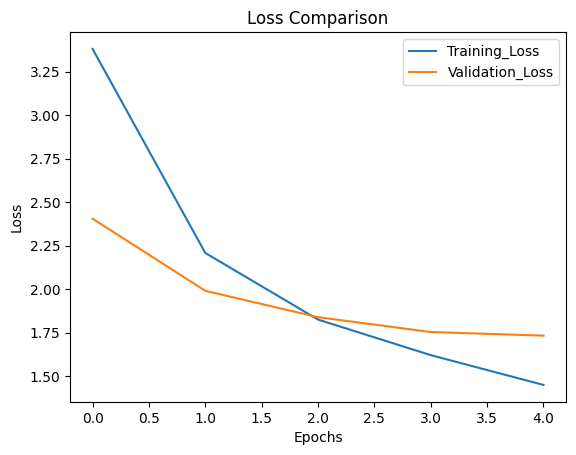

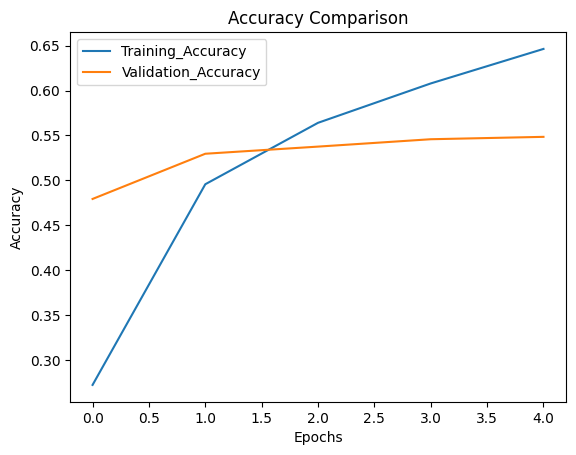

In [35]:
import matplotlib.pyplot as plt
loss = history_all_classes_10_percent.history['loss']
val_loss = history_all_classes_10_percent.history['val_loss']

accuracy = history_all_classes_10_percent.history['accuracy']
val_accuracy = history_all_classes_10_percent.history['val_accuracy']

epochs = range(len(loss))

plt.figure()
plt.plot(epochs,loss, label='Training_Loss')
plt.plot(epochs,val_loss, label='Validation_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.legend()

plt.figure()
plt.plot(epochs,accuracy, label='Training_Accuracy')
plt.plot(epochs,val_accuracy, label='Validation_Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()
plt.show()

In [40]:
base_model.trainable = True
for layer in base_model.layers[:-5]:
  layer.trainable = False
  #print(layer.name, layer.trainable)


In [41]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])

In [42]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [45]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [47]:
fine_tune_epochs = 10

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data = test_data,
                                                     validation_steps= int(0.15*len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 33s 141ms/step - loss: 1.1748 - accuracy: 0.6925 - val_loss: 1.6708 - val_accuracy: 0.5580
Epoch 6/10
237/237 [==============================] - 24s 103ms/step - loss: 1.0782 - accuracy: 0.7175 - val_loss: 1.6958 - val_accuracy: 0.5548
Epoch 7/10
237/237 [==============================] - 21s 90ms/step - loss: 0.9781 - accuracy: 0.7377 - val_loss: 1.7189 - val_accuracy: 0.5458
Epoch 8/10
237/237 [==============================] - 19s 79ms/step - loss: 0.9307 - accuracy: 0.7485 - val_loss: 1.6977 - val_accuracy: 0.5540
Epoch 9/10
237/237 [==============================] - 18s 74ms/step - loss: 0.8647 - accuracy: 0.7628 - val_loss: 1.6741 - val_accuracy: 0.5591
Epoch 10/10
237/237 [==============================] - 17s 71ms/step - loss: 0.8233 - accuracy: 0.7785 - val_loss: 1.7055 - val_accuracy: 0.5583


In [48]:
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 17s 21ms/step - loss: 1.5114 - accuracy: 0.6003


[1.5113602876663208, 0.6003168225288391]

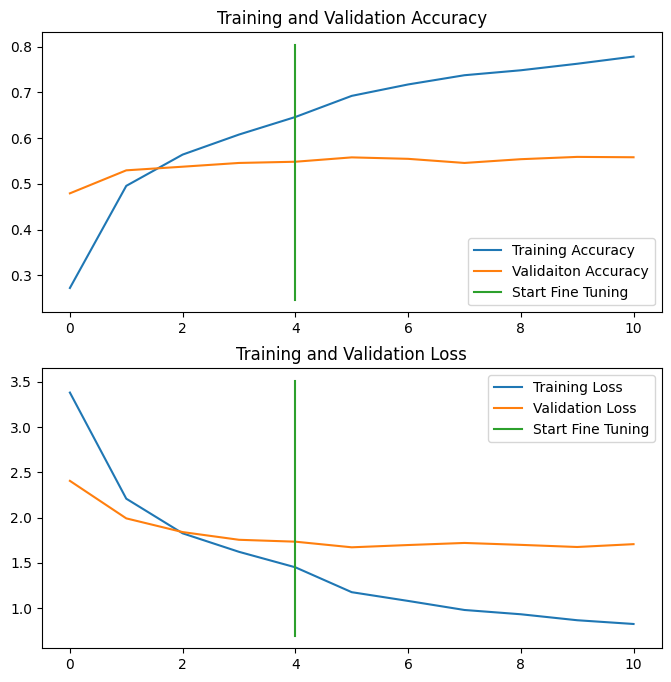

In [56]:
original_history = history_all_classes_10_percent
new_history = history_all_classes_10_percent_fine_tune
initial_epochs= 5

acc = original_history.history['accuracy']
val_acc = original_history.history['val_accuracy']

loss = original_history.history['loss']
val_loss = original_history.history['val_loss']

total_acc = acc + new_history.history['accuracy']
val_total_acc = val_acc + new_history.history['val_accuracy']

total_loss = loss + new_history.history['loss']
val_total_loss = val_loss +new_history.history['val_loss']


plt.figure(figsize=(8,8))
plt.subplot(2, 1, 1)
plt.plot(total_acc, label='Training Accuracy')
plt.plot(val_total_acc, label='Validaiton Accuracy')
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(2,1,2)
plt.plot(total_loss, label='Training Loss')
plt.plot(val_total_loss, label='Validation Loss')
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



In [60]:
#model.save('drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model')

In [58]:
tf.__version__

'2.12.0'

In [61]:
import tensorflow as tf

In [62]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2023-05-18 04:20:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 142.250.141.128, 2607:f8b0:4023:c0b::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   210MB/s    in 0.2s    

2023-05-18 04:20:43 (210 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [64]:
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"

import zipfile



In [66]:
zip_ref = zipfile.ZipFile(saved_model_path)
zip_ref.extractall()
zip_ref.close()

In [67]:
model = tf.keras.models.load_model(saved_model_path.split('.')[0])

In [68]:
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

790/790 [==============================] - 19s 22ms/step - loss: 1.8022 - accuracy: 0.6078


(1.8021684885025024, 0.6078019738197327)

In [69]:
pred_probs = model.predict(test_data, verbose=0)

In [70]:
len(pred_probs)

25250

In [71]:
pred_probs.shape

(25250, 101)

In [72]:
pred_probs[:10]

array([[5.9555572e-02, 3.5662119e-06, 4.1279349e-02, ..., 1.4194699e-09,
        8.4039129e-05, 3.0820314e-03],
       [9.6338320e-01, 1.3765826e-09, 8.5042708e-04, ..., 5.4804143e-05,
        7.8341188e-12, 9.7811304e-10],
       [9.5942634e-01, 3.2432759e-05, 1.4769287e-03, ..., 7.1438910e-07,
        5.5323352e-07, 4.0179562e-05],
       ...,
       [4.7279873e-01, 1.2954312e-07, 1.4748254e-03, ..., 5.9630687e-04,
        6.7163957e-05, 2.3532135e-05],
       [4.4502247e-02, 4.7261000e-07, 1.2174438e-01, ..., 6.2917384e-06,
        7.5576504e-06, 3.6633476e-03],
       [7.2373080e-01, 1.9256416e-09, 5.2089705e-05, ..., 1.2218992e-03,
        1.5755526e-09, 9.6206924e-05]], dtype=float32)

In [73]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [75]:
y_labels =[]

for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [76]:
len(y_labels)

25250

In [77]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6078019801980198